In [28]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_jit_num_clus_pro as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [29]:

model = toy.SmolModel(None,None)


true_parameters = [0.0002, 0.0025, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


Init 1
[[5.00000000e+002 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.99500317e+002 2.62139880e-001 1.37561024e-004 ... 6.35986003e-319
  2.51973479e-322 0.00000000e+000]
 [4.99001370e+002 5.23506860e-001 5.49205579e-004 ... 2.89955856e-284
  3.04971525e-287 3.20351438e-290]
 ...
 [2.78359318e+000 2.84437375e+000 2.90570097e+000 ... 1.97133509e+001
  2.03015070e+001 2.09216123e+001]
 [2.77900802e+000 2.83988115e+000 2.90130497e+000 ... 1.97643931e+001
  2.03546617e+001 2.09769895e+001]
 [2.77442406e+000 2.83538944e+000 2.89690957e+000 ... 1.98155610e+001
  2.04079486e+001 2.10325060e+001]]
(9700, 100)


Perfect data

In [37]:
values = org_values
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 5000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_62564/4258958434.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     156     0:02.9
2     264     0:03.7
3     375     0:04.4
20    2088    0:14.5
40    4152    0:25.7
60    6054    0:35.5
80    8157    0:46.9
100   10344   1:00.9
120   12588   1:12.3
140   15006   1:25.2
160   19371   1:47.8
180   23982   2:11.4
200   28623   2:34.9
220   33000   2:58.0
240   37584   3:22.6
260   41994   3:46.3
280   46797   4:11.9
300   51129   4:35.1
320   55503   4:59.3
340   59697   5:21.7
360   64113   5:45.7
380   68469   6:09.0
400   72999   6:33.2
420   77091   6:55.4
440   81351   7:18.4
460   85608   7:41.4
480   89865   8:04.2
500   94587   8:29.5
520   99009   8:53.2
540   103398   9:16.7
560   107682   9:39.5
580   111255   9:58.6
600   115323  10:20.4
620   119832  10:44.7
640   124311  11:07.3
660   128919  11:30.6
680   133422  11:53.5
700   137700  12:14.8
720   142146  12:37.2
740   146067  12:57.2
760   150120  13:17.8
780 

In [38]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


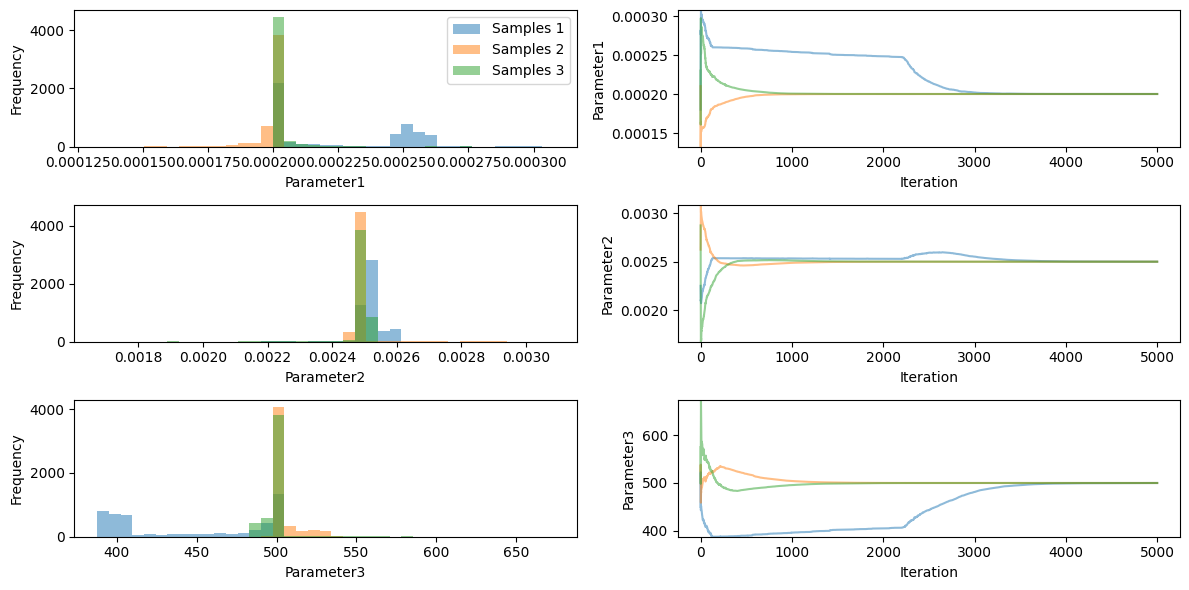

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  1.25e-08  0.0002  0.0002  0.0002  0.0002  0.0002   3.23    10.5   0.0016
p        0.0025  4.9e-07   0.0025  0.0025  0.0025  0.0025  0.0025   2.42    9.9    0.00152
N        500     0.166     499     500     500     500     500      2.59    9.8    0.0015


In [43]:
pints.plot.trace(chains)
plt.savefig("perfect_data_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(4*ITERS/5):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

Multiplicative noise

In [33]:
noise = 1
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_62564/3381684360.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


1     177     0:02.5
2     336     0:04.1
3     405     0:04.5
20    2319    0:15.4
40    4833    0:28.9
60    7320    0:43.3
80    9906    0:57.5
100   12495   1:11.9
120   14985   1:25.3
140   17751   1:40.2
160   20358   1:54.2
180   23148   2:09.2
200   25728   2:22.9
220   28524   2:38.0
240   30984   2:51.2
260   33654   3:05.6
280   36357   3:20.1
300   38982   3:34.2
320   41772   3:49.6
340   44466   4:04.8
360   47247   4:19.9
380   49818   4:34.7
400   52542   4:48.9
420   55134   5:02.1
440   57939   5:17.2
460   60498   5:30.6
480   63180   5:44.4
500   65793   5:57.5
520   68625   6:12.2
540   71337   6:26.2
560   74037   6:40.8
580   76755   6:56.5
600   79497   7:11.0
620   82341   7:25.7
640   85194   7:40.6
660   87846   7:54.5
680   90498   8:08.3
700   93078   8:21.5
720   95610   8:34.6
740   98340   8:48.6
760   101091   9:02.8
780   103875   9:17.2
800   106593   9:33.6
820   109254   9:50.3
840   112032  10:06.1
860   114744  10:21.2
880   117333  10:35.4
900   

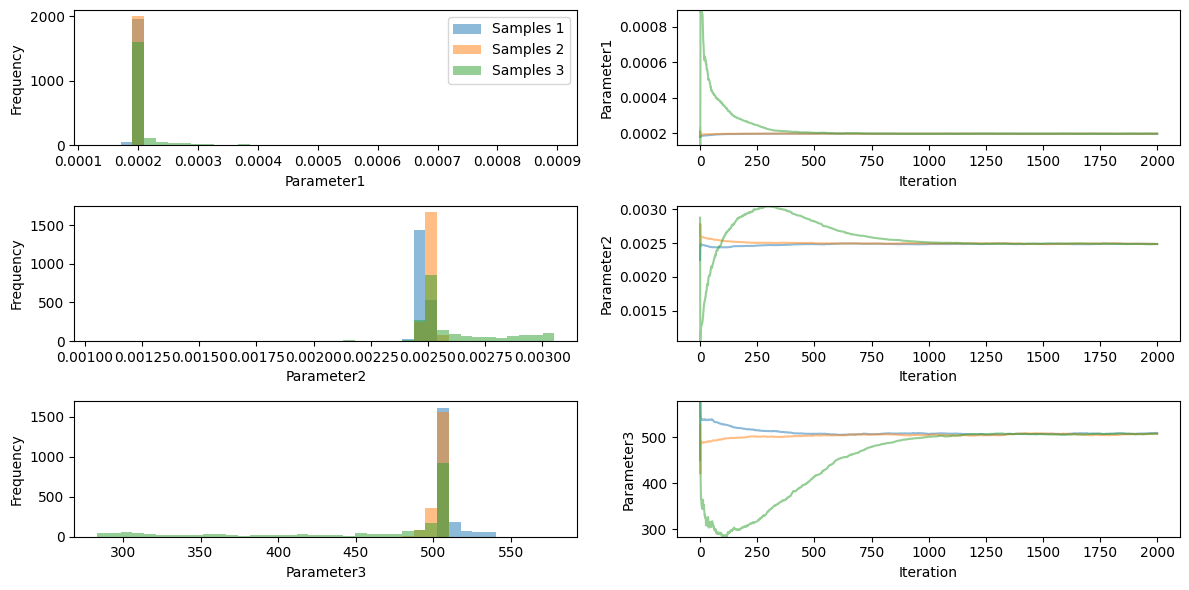

<class '__main__.MyMCMCSummary'>
param    mean      std.     2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
-------  --------  -------  --------  --------  --------  --------  --------  ------  -----  --------------
b        0.000198  3.2e-07  0.000197  0.000198  0.000198  0.000198  0.000199  1.09    33.6   0.0244
p        0.00249   4.7e-06  0.00248   0.00249   0.00249   0.00249   0.0025    1.24    29.3   0.0213
N        506       1.5      502       506       507       507       508       1.2     20.8   0.0152


In [34]:
pints.plot.trace(chains)
plt.savefig("noisy_data_multiplicative_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

Additive noise

In [35]:
noise = 1
values = org_values + noise * np.random.normal(0, 0.25, org_values.shape)
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_62564/3091411480.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


1     159     0:01.7
2     258     0:02.2
3     342     0:02.6
20    2304    0:12.7
40    4674    0:24.9
60    6831    0:36.3
80    9030    0:49.6
100   11229   1:00.7
120   13593   1:12.5
140   15795   1:23.5
160   18063   1:34.9
180   20487   1:47.1
200   22791   1:58.6
220   25149   2:10.3
240   27396   2:21.6
260   29670   2:33.1
280   31995   2:45.0
300   35670   3:03.3
320   39195   3:21.0
340   42723   3:38.5
360   46239   3:56.1
380   49494   4:12.1
400   53085   4:30.0
420   56550   4:47.5
440   60291   5:06.1
460   63927   5:24.3
480   67530   5:42.2
500   70881   5:58.9
520   74364   6:16.3
540   77721   6:32.8
560   81312   6:50.9
580   84909   7:08.7
600   88434   7:26.3
620   92019   7:44.6
640   95724   8:03.1
660   99336   8:21.0
680   102885   8:38.8
700   106575   8:57.3
720   110046   9:14.6
740   113598   9:32.2
760   117141   9:50.0
780   120873  10:08.7
800   124353  10:26.0
820   127776  10:43.2
840   131253  11:00.7
860   134799  11:18.3
880   138330  11:35.8
90

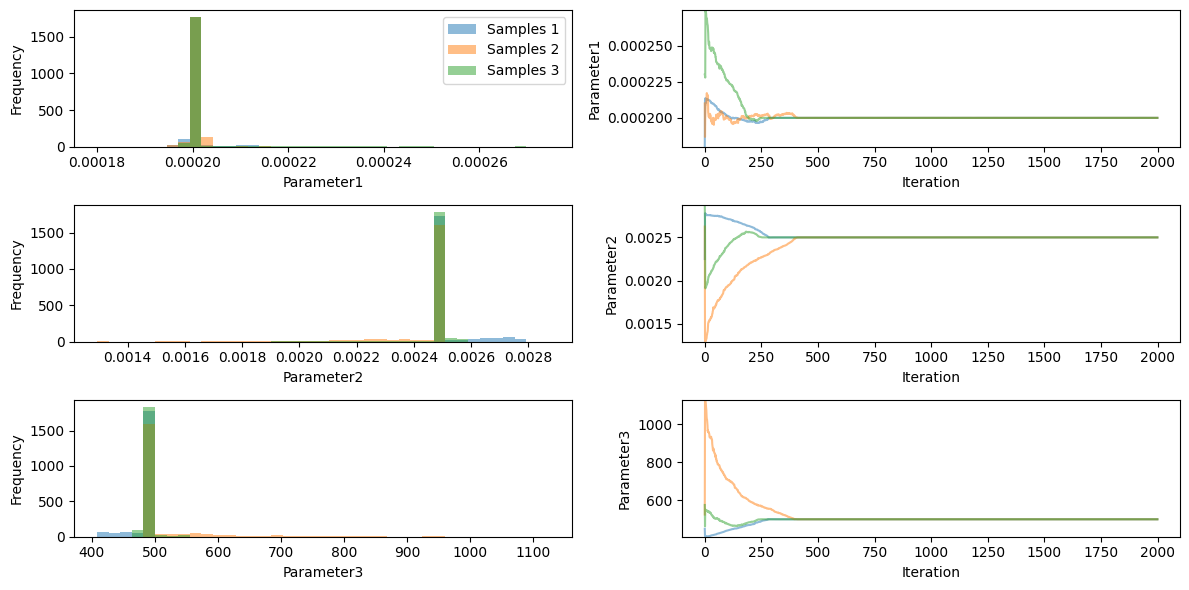

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  5.73e-09  0.0002  0.0002  0.0002  0.0002  0.0002   1       426    0.249
p        0.0025  8.03e-08  0.0025  0.0025  0.0025  0.0025  0.0025   1.01    295    0.172
N        500     0.0138    500     500     500     500     500      1       383    0.224


In [36]:
pints.plot.trace(chains)
plt.savefig("noisy_data_additive_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)